# Animal Shelter (XGBoost+k-NN)


In [371]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Load the Animal Shelter dataset and display a sample.

In [372]:
df = pd.read_csv("train.csv")

In [373]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [374]:
df.describe()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A705677,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824


In [375]:
from sklearn.model_selection import train_test_split
import sklearn

print sklearn.__version__
# Split the dataset into Train/Test
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(df, df[["OutcomeType"]], test_size=0.2, random_state=42, stratify=df[["OutcomeType"]])

print df.shape
print X_train_df.shape
print X_train_df.head()

0.19.1
(26729, 10)
(21383, 10)
      AnimalID    Name             DateTime OutcomeType OutcomeSubtype  \
12647  A710476     NaN  2015-08-25 15:18:00    Transfer        Partner   
16303  A703907    Fawn  2015-06-08 16:25:00    Transfer        Partner   
3792   A700136     NaN  2015-04-18 14:22:00        Died      In Foster   
13021  A664073  Parker  2013-10-07 17:06:00    Adoption            NaN   
4295   A716795     NaN  2015-11-29 08:57:00  Euthanasia    Rabies Risk   

      AnimalType SexuponOutcome AgeuponOutcome                   Breed  \
12647        Cat    Intact Male        1 month  Domestic Shorthair Mix   
16303        Cat    Intact Male        4 weeks  Domestic Shorthair Mix   
3792         Cat    Intact Male        4 weeks  Domestic Shorthair Mix   
13021        Dog  Neutered Male        2 years            Hovawart Mix   
4295         Cat        Unknown       2 months  Domestic Shorthair Mix   

                      Color  
12647          Orange Tabby  
16303              

# 1. Data  Preparation


Split the "SexuponOutcome" field into "Sex" and "Neutered".

In [376]:
def splitSex(df):
    print "splitSex..."
    df.loc[df["SexuponOutcome"].isnull(), "SexuponOutcome"]="unknown"

    df["Sex"] = df["SexuponOutcome"].str.lower().str.contains(" male")
    df.loc[df["SexuponOutcome"].str.lower().str.contains(" male"), "Sex"] = "male"
    df.loc[df["SexuponOutcome"].str.lower().str.contains("female"), "Sex"] = "female"
    df.loc[df["SexuponOutcome"].str.lower().str.contains("unknown"), "Sex"] = "unknown"

    df["Neutered"] = (df["SexuponOutcome"].str.lower().str.contains("neutered")) |  (df["SexuponOutcome"].str.lower().str.contains("spayed"))
    df["Neutered"] = df["Neutered"].astype(int)


In [377]:
def processName(df):
    print "processName..."
    
    df["HasName"] = ~df["Name"].isnull()
    df["HasName"] = df["HasName"].astype(int)


Clean up the breed field. Here we determine if an animal is a purebreed or a mix and create a new field encoding this information.

In [378]:
def cleanupBreed(df):
    print "cleanupBreed..."
    
    df["PureBreed"] = ~df["Breed"].str.lower().str.contains("mix")
    df.loc[df["Breed"].str.contains("/"), "PureBreed"]=False
    df["PureBreed"] = df["PureBreed"].astype(int)
    df[["Breed", "PureBreed"]].head(10)
    
cleanupBreed(df)

cleanupBreed...


The dog breed potentially encodes information that could improve classifier predictions, such as size of dog, breed popularity, breed temperament and longevity etc. This information, however is difficult to extract from the breed. Instead we encode the breed field into a set of features that can then be used by the classifier. The breed field is transformed into features by calculating a term-document matrix taking the rows in the Breed column as the document corpus. This results in the breed words being vectorized. 

This should allow the classifier to implicitly infer information regarding the breeds which affects the outcome. For example if chihuahuas or chihuahua mixes are unpopular for adoption, any breed mentioning chihuahua should result in a lower probability of adoption in the classifier. If medium sized breeds tend to be adopted more frequently, this should also be a correlation that emerges in the classifier. 

In [379]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

breedsVec = CountVectorizer()
pca = PCA()

def fitPCA(df):
    print "fitPCA..."
    breedsTDM = breedsVec.transform(df["Breed"])
    pca.fit(breedsTDM.toarray())
    
def preprocessBreed(df):
    print "preprocessBreed..."
    #vec = CountVectorizer()
    
    breedsVec.fit(df["Breed"])#.str.replace("Mix", "").str.replace("/", " ").str.lower())
    
    fitPCA(df)
    
    return breedsVec

def processBreed(df, doPCA=0):
    print "processBreed..."
    
    breedsTDM = breedsVec.transform(df["Breed"])#.str.replace("Mix", "").str.replace("/", " ").str.lower())
    print breedsTDM.toarray().shape
    
    if doPCA>0 :

        cumul_variance = [sum(pca.explained_variance_ratio_[:i]) for i in range(len(pca.explained_variance_ratio_))]
        print sum(pca.explained_variance_ratio_[:3])
       # print pca.explained_variance_ratio_
        #print cumul_variance

        numDims = len(cumul_variance)
        for i in range(len(cumul_variance)):
            if cumul_variance[i]>=doPCA:
                numDims = i
                break

        print "NumDims=", numDims

        reduced_dims = pca.transform(breedsTDM.toarray())
        reduced_dims = reduced_dims[:,:numDims]

        print reduced_dims.shape
        breedsdf = pd.DataFrame(reduced_dims)#breedsTDM.toarray())
        breedCols = ["Breed_"+str(i) for i in range(0, reduced_dims.shape[1]) ]
        breedsdf.columns = breedCols
        #print breedsdf.head()

        df = df.join(breedsdf)
    else:
        breedsdf = pd.DataFrame(breedsTDM.toarray())
        breedCols = ["Breed_"+breedsVec.get_feature_names()[i] for i in range(0, breedsTDM.shape[1]) ]
        breedsdf.columns = breedCols
        #print breedsdf.head()

        df = df.join(breedsdf)

    
    #print df.head()
    return df


#preprocessBreed(df)
#df = processBreed(df, False)
#df.head()


We define a function that translates the age fields in the dataset to days by parsing the units (year(s), month(s), week(s)). We then map the age in days to an ageBracket field so as to categories the animals as (BABY, JUVENILE, ADULT, SENIOR). Animal shelters do not allow animals to be adopted before they are weaned, therefore the "BABY" bracket should add resultion to our classifier.

In [380]:
def getAgeInDays(ageStr):
    if pd.isnull(ageStr):
        return ageStr
    
    ageParts = ageStr.lower().split(" ")
    val = int(ageParts[0])
    units = ageParts[1]
    
    if units[-1:]=="s":
        units = units[0:-1]
    
    if units=="year":
        val = 365*val
    elif units=="month":
        val = 30*val
    elif units=="week":
        val = 7*val
    
    return val

def getAgeBracket(ageInDays):
    if ageInDays<=42:
        return "baby"
    elif ageInDays<=365:
        return "juvenile"
    elif ageInDays<=365*9:
        return "adult"
    else:
        return "senior"

    
def processAge(df):
    print "processAge..."
    
    df["AgeDays"] = df["AgeuponOutcome"].apply(getAgeInDays)
    meanAge = df[["AgeDays"]].mean()

    df.loc[df["AgeDays"].isnull(), "AgeDays"]=meanAge[0]
    df["AgeBracket"] = df["AgeDays"].apply(getAgeBracket)
    
    
#processAge(df)

Here we also take the DateTime column and we split the day into 3 hour segments. This should tell us the most likely time of day for an outcome. It looks like most adoptions as well as most transfers occur during the afternoon and early evening, peaking around 17:00 (unsurprising as it is the time most people finish their dayjob)

In [381]:
def tsToDaySegment(ts):
    return "HR_"+str(int(ts.hour/3))
    
def processDate(df):
    print "processDate..."
    
    df["DateTime"] = pd.to_datetime(df["DateTime"])
    df["DaySegment"] = df["DateTime"].apply(tsToDaySegment)
    df["OutcomeDay"] = df["DateTime"].dt.day
    df["OutcomeMonth"] = df["DateTime"].dt.month
    df["OutcomeHour"] = df["DateTime"].dt.hour
    
#processDate(df)


Create an "IsWeekend" feature to hopefully help the classifier along.

In [382]:
def processWeekend(df):
    print "processWeekend..."
    
    df["IsWeekend"] = df["DateTime"].apply(lambda ts: (ts.weekday()>=5))
    df["IsWeekend"] = df["IsWeekend"].astype(int)

#processWeekend(df)


Does having a name make a difference to the outcome? Yes. Having a name is much more likely to result in adoption and/or return to owner.

In [383]:
def processName(df):
    print "processName..."
    
    df["HasName"] = ~df["Name"].isnull()
    df["HasName"] = df["HasName"].astype(int)


#processName(df)


We also need to simplify the color field. There are too many unique colors. We do this by splitting on "/" or " " and taking only the first word.

In [384]:
#df["SimpleColor"] = df["Color"].apply(lambda c: c.split("/| ")[0])
def processColor(df):
    print "processColor..."
    
    df["SimpleColor"] = df["Color"].apply(lambda c: c.lower().split("/")[0].split(" ")[0])


#processColor(df)


In [385]:
from sklearn import preprocessing
# Need to install sklearn_pandas for DataFrameMapper. This is more flexible than sklearn pipeline
# because it can perform separate operations on different columns of the dataframe.
# pip install sklearn-pandas
from sklearn_pandas import DataFrameMapper

mapper = DataFrameMapper([
     ("AnimalType", preprocessing.LabelBinarizer()),
     ("Sex", preprocessing.LabelBinarizer()),
     ("Neutered", preprocessing.LabelBinarizer()),
     ("PureBreed", preprocessing.LabelBinarizer()),
     ("AgeBracket", preprocessing.LabelBinarizer()),
     ("DaySegment", preprocessing.LabelBinarizer()),
     ("IsWeekend", preprocessing.LabelBinarizer()),
     ("HasName", preprocessing.LabelBinarizer()),
     ("SimpleColor", None),
], default=None, df_out=True)

labelMapper = DataFrameMapper([
    ("OutcomeType", preprocessing.LabelEncoder()),
], df_out=True)




In [386]:
def prepareDFForPrediction(df_x, df_y=None, doPCA=False):
    df_x_c = df_x.copy()
    
    splitSex(df_x_c)
    cleanupBreed(df_x_c)
    df_x_c = processBreed(df_x_c, doPCA) 
    processAge(df_x_c)    
    processDate(df_x_c)
    processWeekend(df_x_c)
    processName(df_x_c)
    processColor(df_x_c)
    
    # Transform the independent features
    df_x_c = mapper.fit_transform(df_x_c)
    
    if df_y is not None:
        # Transform the target field
        df_y_c = labelMapper.fit_transform(df_y)
    else:
        df_y_c = None
        
    df_x_c = df_x_c.drop(["Name", "DateTime", "SexuponOutcome", "AgeuponOutcome", "Breed", "Color", "Sex_unknown",  "AgeBracket_senior", "SimpleColor"], axis=1)

    if "AnimalID" in df_x_c.columns.values:
        df_x_c = df_x_c.drop(["AnimalID"], axis=1)
        
    if "OutcomeSubtype" in df_x_c.columns.values:
        df_x_c = df_x_c.drop(["OutcomeSubtype"], axis=1)
        
    if "OutcomeType" in df_x_c.columns.values:
        df_x_c = df_x_c.drop(["OutcomeType"], axis=1)     
   

    df_x_c.fillna(value=0, inplace=True)
    
    return df_x_c, df_y_c
    

How balanced or unbalanced are our classes?

It is clear that there is a severe inbalance in the prediction classes.

The simplest solution is to duplicate records in the minority classes, however experiments with this approach resulted in a worse classifier performance.

Instead we use SMOTE (further down) which empirically gives much better results.

In [387]:
#outcomeCounts = df.pivot_table(index=["OutcomeType"], values=["AnimalID"], aggfunc=len)
#
#maxOutcomeCount = np.max(outcomeCounts.values.ravel())
#
#outcomes = df["OutcomeType"].unique()
#
##newrecords = pd.DataFrame(columns=df.columns)
#
#newrecords = pd.DataFrame.from_items(
#    [(name, pd.Series(data=None, dtype=series.dtype)) for name, series in df.iteritems()])
#
#for outcome in outcomes:
#    outcomeCount = outcomeCounts.loc[outcome].values[0]
#    diff = maxOutcomeCount - outcomeCount
#    
#    if diff > 0:
#        subset = pd.DataFrame(df.loc[df["OutcomeType"]==outcome,:])
#        subset = subset.iloc[np.random.randint(0, subset.index.size, size=diff)]
#        print outcome, ": added ", subset.index.size, " records"
#        newrecords = newrecords.append(subset)
#        
#print "Total records added: ", newrecords.index.size

#df = df.append(newrecords)

#sns.countplot(data=df, x="OutcomeType")

# Machine Learning Model

Prepare the dataset for learning

N.B. We will treat OutcomeType as the dependant variable. OutcomeType is directly inferable from OutcomeSubtype, however this goes contrary to the spirit of the Kaggle challenge and the Kaggle testing set does not include this field among the features, therefore in order for our learning algorithm not to be trivial, we will remove this field.

In [388]:
print X_train_df.head()
preprocessBreed(df)
X_train_df, y_train_df = prepareDFForPrediction(X_train_df, y_train_df, doPCA=0)
X_test_df, y_test_df = prepareDFForPrediction(X_test_df, y_test_df, doPCA=0)
print X_train_df.head()

X_train = X_train_df.values
y_train = y_train_df.values

X_test = X_test_df.values
y_test = y_test_df.values

      AnimalID    Name             DateTime OutcomeType OutcomeSubtype  \
12647  A710476     NaN  2015-08-25 15:18:00    Transfer        Partner   
16303  A703907    Fawn  2015-06-08 16:25:00    Transfer        Partner   
3792   A700136     NaN  2015-04-18 14:22:00        Died      In Foster   
13021  A664073  Parker  2013-10-07 17:06:00    Adoption            NaN   
4295   A716795     NaN  2015-11-29 08:57:00  Euthanasia    Rabies Risk   

      AnimalType SexuponOutcome AgeuponOutcome                   Breed  \
12647        Cat    Intact Male        1 month  Domestic Shorthair Mix   
16303        Cat    Intact Male        4 weeks  Domestic Shorthair Mix   
3792         Cat    Intact Male        4 weeks  Domestic Shorthair Mix   
13021        Dog  Neutered Male        2 years            Hovawart Mix   
4295         Cat        Unknown       2 months  Domestic Shorthair Mix   

                      Color  
12647          Orange Tabby  
16303                 Black  
3792            Brow

How balanced or unbalanced are our classes?

# Machine Learning Model

Prepare the dataset for learning

N.B. We will treat OutcomeType as the dependant variable. OutcomeType is directly inferable from OutcomeSubtype, however this goes contrary to the spirit of the Kaggle challenge and the Kaggle testing set does not include this field among the features, therefore in order for our learning algorithm not to be trivial, we will remove this field.

In [389]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,PureBreed
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,0
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,0
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,0
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,0
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,0


Select only the fields we need for learning.

In [390]:
# Experimentally reduce problem to a binary lives/dies classification
def reduceOutcome(outcome):
    return outcome in ("Adoption", "Return_to_owner", "Transfer")

# reduce outcome classes to lives/dies
def prepareOutcome(df):
    df["OutcomeTypeReduced"]=df["OutcomeType"].apply(reduceOutcome)



Pre-process our fields to make them suitable for passing to a machine learning algorithm.

In [391]:
# Generate simplified outcomes (lives/dies)
def getSimpleOutcome(outcomes):
    return [o in (0, 3, 4) for o in outcomes[:,0]]

y_train_simple=getSimpleOutcome(y_train)
y_test_simple=getSimpleOutcome(y_test)


In [392]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plotROCCurves(classes, classlabels, y_test_bin, y_test_proba):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(0, len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    print int(np.ceil(float(len(classes))/2)), 2
    f, plts = plt.subplots(int(np.ceil(float(len(classes))/2)), 2, figsize=(10, 10))

    plts = plts.ravel()
    lw = 2

    #classlabels=labelMapper.features[0][1].inverse_transform(classes)

    for cls in range(0, len(plts)):#range(0, clf2.n_classes_):
        #plt.subplot(3,2,cls+1)
        if (cls < len(classes)):
            plts[cls].plot(fpr[cls], tpr[cls], color='darkorange',
                     lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[cls])
            plts[cls].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
            plts[cls].set_xlim([0.0, 1.0])
            plts[cls].set_ylim([0.0, 1.05])
            plts[cls].set_xlabel('False Positive Rate')
            plts[cls].set_ylabel('True Positive Rate')
            plts[cls].set_title('ROC curve - '+classlabels[cls]+"(AUC = " + str(round(roc_auc[cls], 2))+ ")")
            plt.legend(loc="lower right")
        else:
            plts[cls].axis("off")

    f.subplots_adjust(hspace=0.4)
    plt.show()
    


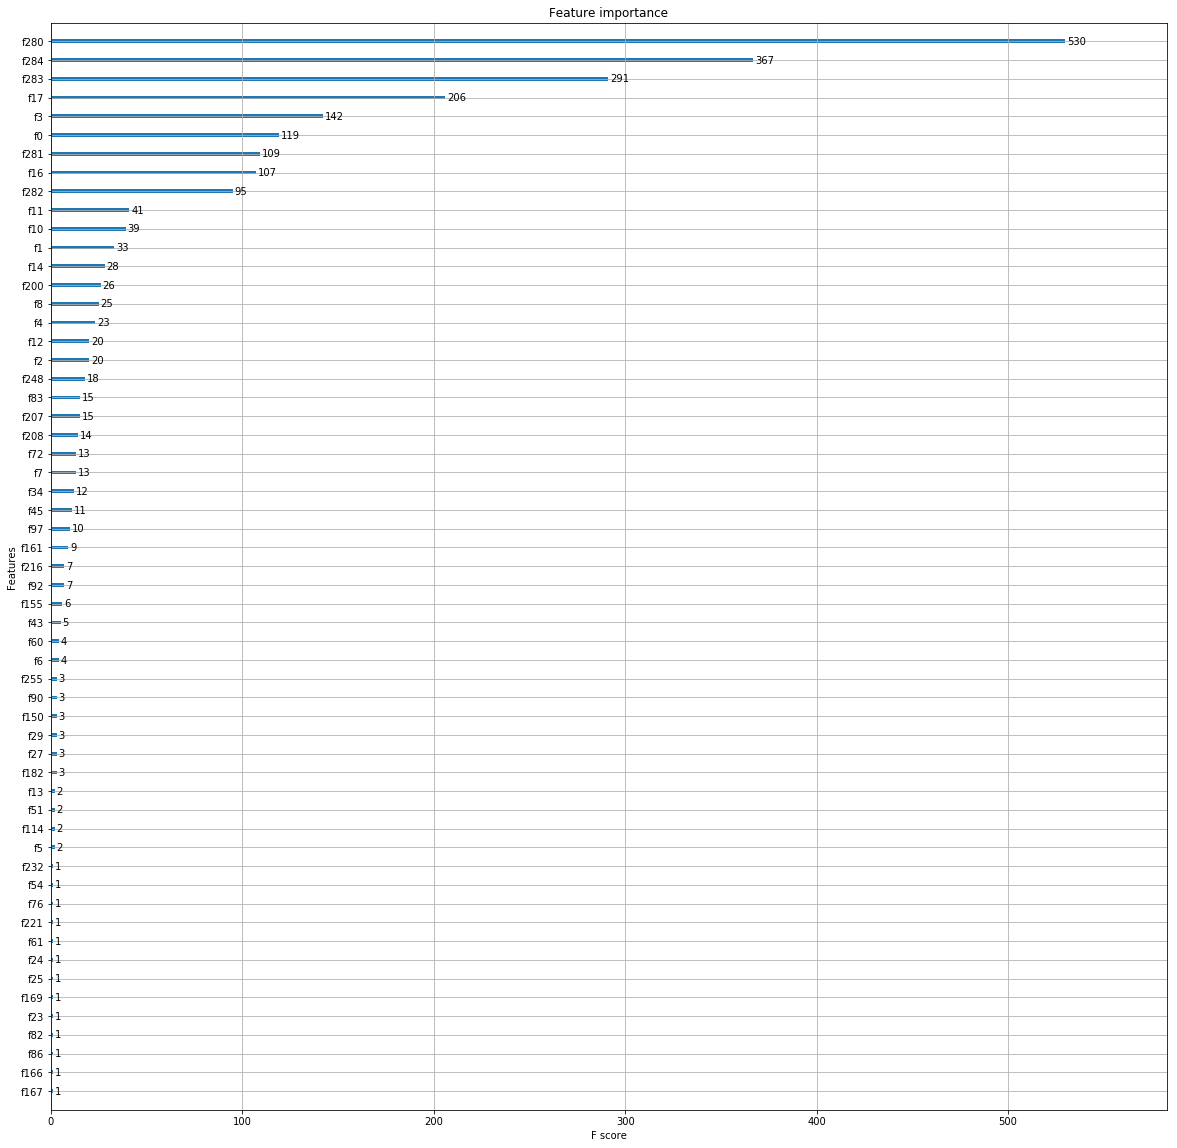

Threshold= 1e-05 : Re-fitting with  57  features instead of  285
f1 score(cv)= [ 0.72491127  0.71857937  0.72820319]
log loss(cv)= [-0.61564702 -0.61709199 -0.60193291]
f1 score(test)= 0.718632629744
log loss(test)= 0.626611151415
Threshold= 2.78255940221e-05 : Re-fitting with  57  features instead of  285
f1 score(cv)= [ 0.72637994  0.73045713  0.71344935]
log loss(cv)= [-0.60983215 -0.60972155 -0.61759419]
f1 score(test)= 0.718632629744
log loss(test)= 0.626611151415
Threshold= 7.74263682681e-05 : Re-fitting with  57  features instead of  285
f1 score(cv)= [ 0.72548849  0.71938527  0.72515168]
log loss(cv)= [-0.60663903 -0.61870749 -0.60889935]
f1 score(test)= 0.718632629744
log loss(test)= 0.626611151415
Threshold= 0.000215443469003 : Re-fitting with  57  features instead of  285
f1 score(cv)= [ 0.72009408  0.72375484  0.72640201]
log loss(cv)= [-0.61632962 -0.61045572 -0.60764795]
f1 score(test)= 0.718632629744
log loss(test)= 0.626611151415
Threshold= 0.000599484250319 : Re-fittin

In [394]:
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score

# Define an instance of XGBoost and fit the training set to it
fselGB = xgb.XGBClassifier(n_jobs=4)

# Fit the classifier to the training set+simple outcomes
fselGB.fit(np.hstack((X_train, np.array(y_train_simple)[np.newaxis].T)), y_train[:,0])

# Plot feature importances visually
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_importance(fselGB, ax=ax)
plt.show()

# In order to determine which features tp select for our model, we iterate on a threshold value.
# Any feature with an importance value smaller than the threshold is removed and the model performance
# is determined in terms of f1 score and log loss. 
# In this way we determine the threshold value at which the performance is maximised and hence which features
# to include in our model.
thresholds_for_test = np.geomspace(0.00001, 0.1, 10, endpoint=True)
f1scorescv=[]
loglossescv=[]
f1scorestest=[]
loglossestest=[]
paramsleft=[]
for thresh in thresholds_for_test:
    support = fselGB.feature_importances_>thresh
    print "Threshold=", thresh, ": Re-fitting with ", np.sum(support), " features instead of ", len(support)
    
    GB2 = xgb.XGBClassifier(n_jobs=4)

    
    stcv = StratifiedKFold(y_train[:,0],n_folds=3,shuffle=True)
    loglosscv = cross_val_score(GB2, np.hstack((X_train, np.array(y_train_simple)[np.newaxis].T))[:, support], y_train[:,0], cv=stcv, scoring="neg_log_loss")
    f1cv = cross_val_score(GB2, np.hstack((X_train, np.array(y_train_simple)[np.newaxis].T))[:, support], y_train[:,0], cv=stcv, scoring="f1_weighted")
    print "f1 score(cv)=", f1cv
    print "log loss(cv)=", loglosscv
    
    GB2.fit(np.hstack((X_train, np.array(y_train_simple)[np.newaxis].T))[:, support], y_train[:,0])

    preds = GB2.predict(np.hstack((X_test, np.array(y_test_simple)[np.newaxis].T))[:, support])
    proba = GB2.predict_proba(np.hstack((X_test, np.array(y_test_simple)[np.newaxis].T))[:, support])

    f1score = f1_score(y_test, preds, average="weighted")
    logloss = log_loss(y_test, proba, labels=GB2.classes_)
    print "f1 score(test)=", f1score
    print "log loss(test)=", logloss

    f1scorescv.append(np.mean(f1cv))
    loglossescv.append(np.mean(loglosscv))
    f1scorestest.append(f1score)
    loglossestest.append(logloss)
    paramsleft.append(np.sum(support))


In [349]:
xgbresults = [thresholds_for_test, paramsleft, f1scores, loglosses]
print xgbresults

[array([  1.00000000e-05,   2.78255940e-05,   7.74263683e-05,
         2.15443469e-04,   5.99484250e-04,   1.66810054e-03,
         4.64158883e-03,   1.29154967e-02,   3.59381366e-02,
         1.00000000e-01]), [57, 57, 57, 57, 44, 32, 25, 12, 9, 3], [0.71863262974430753, 0.71863262974430753, 0.71863262974430753, 0.71863262974430753, 0.71767528058949515, 0.71806911778882199, 0.71931940218122159, 0.71803091610998893, 0.71596466093852451, 0.6304929936333612], [0.62661115141505164, 0.62661115141505164, 0.62661115141505164, 0.62661115141505164, 0.62617079741214365, 0.62544036244839751, 0.6254054721718092, 0.6253905505105436, 0.6270438258428499, 0.7585206750306146]]


[  1.00000000e-05   2.78255940e-05   7.74263683e-05   2.15443469e-04
   5.99484250e-04   1.66810054e-03   4.64158883e-03   1.29154967e-02
   3.59381366e-02   1.00000000e-01]
[0.71863262974430753, 0.71863262974430753, 0.71863262974430753, 0.71863262974430753, 0.71767528058949515, 0.71806911778882199, 0.71931940218122159, 0.71803091610998893, 0.71596466093852451, 0.6304929936333612]
[0.62661115141505164, 0.62661115141505164, 0.62661115141505164, 0.62661115141505164, 0.62617079741214365, 0.62544036244839751, 0.6254054721718092, 0.6253905505105436, 0.6270438258428499, 0.7585206750306146]
Will use threshold  0.00877854274188
[ True  True False  True  True False False False  True False  True  True
 False False  True False  True  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False 

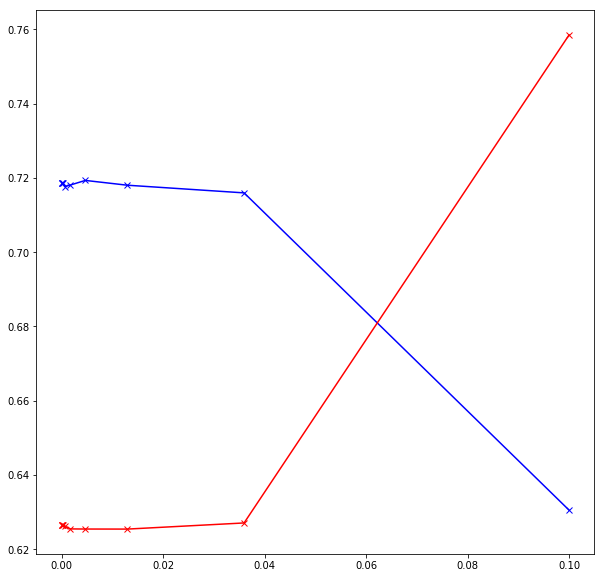

In [350]:
print thresholds_for_test
print f1scores
print loglosses

f, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))
ax1.plot(thresholds_for_test, f1scorescv, "bx-", thresholds_for_test, f1scorestest, "rx-")
ax2.plot(thresholds_for_test, [abs(loglossescv[i]) for i in range(len(loglossescv))], "bx-", thresholds_for_test, loglossestest, "rx-")

# Select an optimum threshold
f1_thresh = np.argsort(f1scorestest)[-1]
ll_thresh = np.argsort(loglossestest)[0]

# Average the two
final_threshold = np.average((thresholds_for_test[f1_thresh], thresholds_for_test[ll_thresh]))

# final_support is now a boolean array masking out the most important features.
final_support = fselGB.feature_importances_>=final_threshold

print "Will use threshold ", final_threshold
print final_support

# Save the contents of X_test before feature reduction.
#X_test_pre_red = X_test

# Reduce the features on the training and test sets
X_train = np.hstack((X_train, np.array(y_train_simple)[np.newaxis].T))[:,final_support]
X_test = np.hstack((X_test, np.array(y_test_simple)[np.newaxis].T))[:, final_support][:,:-1]


0.966018007552
0.340696178775
(21383, 16)
21383
[[4]
 [4]
 [1]
 ..., 
 [4]
 [4]
 [4]]
(5346,)
(5346, 2)
1 2


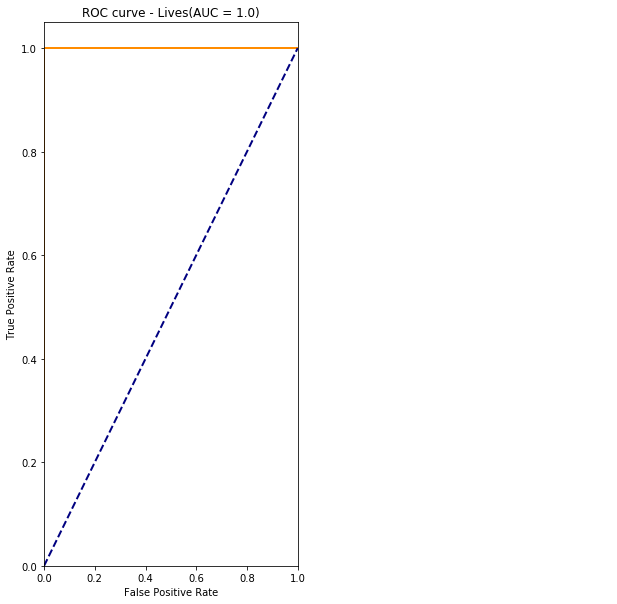

In [351]:
#from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

#preclf = MultinomialNB()
preclf = KNeighborsClassifier(weights="distance", n_neighbors=100, n_jobs=-1)
preclf.fit(X_train[:,:-1], y_train_simple) # slice out the simpleoutcome field

prepreds = preclf.predict(X_test)
preproba = preclf.predict_proba(X_test)

print f1_score(y_test_simple, prepreds)
print log_loss(y_test_simple, preproba)

print X_train.shape
print len(y_train_simple)
print y_train

print prepreds.shape
print preproba.shape

plotROCCurves([1], ["Lives"], np.transpose(prepreds[np.newaxis]), np.transpose(preproba[:,1][np.newaxis]))


In [353]:
sortedIndexes = np.argsort(fselGB.feature_importances_)[::-1]
colnames= X_test_df.columns.values
colnames = np.append(colnames, "SimpleOutcome")

print colnames[sortedIndexes][final_support[sortedIndexes]]

['AgeDays' 'SimpleOutcome' 'OutcomeHour' 'HasName' 'Neutered' 'AnimalType'
 'OutcomeDay' 'IsWeekend' 'OutcomeMonth' 'DaySegment_HR_3'
 'DaySegment_HR_2' 'Sex_female' 'DaySegment_HR_6' u'Breed_poodle'
 'DaySegment_HR_0' 'PureBreed']


In [47]:
from sklearn.cross_validation import StratifiedKFold
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
# We use the genetic algorithm cross validation search library at https://github.com/rsteca/sklearn-deap 
# in order to optimize the XGBoost Hyperparameters.
from evolutionary_search import EvolutionaryAlgorithmSearchCV

# Ideally we use approx. 10 folds
k_fold = 3
  
# Use Stratified KFold so as to mitigate the effects of the imbalanced dataset.
# Stratified k-fold makes sure that the cross validation folds are always selected with the same 
# ratio of outcome classes
cv = StratifiedKFold(y_train[:,0],n_folds=k_fold,shuffle=True)
  
# initialize the classifier
GB = xgb.XGBClassifier()
  
# Define the hyperparamer ranges inside which we want to optimize our model
param_grid = {'max_depth': [500],
              'learning_rate': np.arange(0.1,0.5, 0.1),
              'objective':['multi:softprob'],
              'n_jobs': [2],
              'missing': [np.nan],
              'reg_alpha': np.geomspace(3, 15, 10, endpoint=True),
              'colsample_bytree': np.arange(0.25, 0.55, 0.02),
              'colsample_bylevel': np.arange(0.45, 0.85, 0.2),
              'subsample': np.arange(0.80, 1, 0.01),
              'n_estimators': np.arange(50, 300, 20)}

search_GB = EvolutionaryAlgorithmSearchCV(estimator=GB,
                                   params=param_grid,
                                   scoring="neg_log_loss",
                                   cv=cv,
                                   verbose=10,
                                   population_size=50,
                                   gene_mutation_prob=0.20,
                                   gene_crossover_prob=0.5,
                                   tournament_size=5,
                                   generations_number=10,
                                   n_jobs=3)

search_GB.fit(X_train,y_train[:,0])
print ' ',search_GB.best_score_
print ' ',search_GB.best_params_



Types [1, 2, 2, 1, 2, 2, 1, 2, 2, 1] and maxint [12, 19, 9, 0, 15, 0, 0, 3, 1, 0] detected


/home/etienne/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.39, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=90, subsample=0.87, objective=multi:softprob, max_depth=500 
--- Evolve in 332800 possible combinations ---
[CV] reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.27, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=50, subsample=0.95, objective=multi:softprob, max_depth=500 
[CV] reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.92, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.27, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=50, subsample=0.95, objective=multi:softprob, max_depth=500, score=-0.760687794984, total=   1.8s
[CV] reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.27, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=50, subsamp

[CV] reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.31, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=90, subsample=0.96, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=15.0, n_jobs=2, colsample_bytree=0.35, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=170, subsample=0.85, objective=multi:softprob, max_depth=500, score=-0.594493160094, total=   5.0s
[CV] reg_alpha=15.0, n_jobs=2, colsample_bytree=0.35, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=170, subsample=0.85, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.55, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.81, objective=multi:softprob, max_depth=500, score=-0.605006430282, total=  12.3s
[CV] reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.55, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.81, objective=mult

[CV]  reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.47, missing=nan, learning_rate=0.2, colsample_bylevel=0.45, n_estimators=70, subsample=0.86, objective=multi:softprob, max_depth=500, score=-0.61533773399, total=   2.8s
[CV] reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=50, subsample=0.96, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.4, colsample_bylevel=0.45, n_estimators=130, subsample=0.87, objective=multi:softprob, max_depth=500, score=-0.591842320079, total=   5.3s
[CV] reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.4, colsample_bylevel=0.45, n_estimators=130, subsample=0.87, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=15.0, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=90, subsample=0.87, objecti

[CV] reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.25, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=50, subsample=0.99, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=4.28990744493, n_jobs=2, colsample_bytree=0.27, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=170, subsample=0.99, objective=multi:softprob, max_depth=500, score=-0.610073276394, total=   5.2s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.3, colsample_bylevel=0.45, n_estimators=270, subsample=0.82, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.25, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=50, subsample=0.99, objective=multi:softprob, max_depth=500, score=-0.626936111468, total=   1.6s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.29, missing=nan, learning_rate=0.2, colsample_bylevel=0.45, n_estimators=110, subsample=0.85, objectiv

[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.43, missing=nan, learning_rate=0.3, colsample_bylevel=0.45, n_estimators=50, subsample=0.95, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.43, missing=nan, learning_rate=0.3, colsample_bylevel=0.45, n_estimators=50, subsample=0.95, objective=multi:softprob, max_depth=500, score=-0.61660942587, total=   2.0s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.35, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=150, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.31, missing=nan, learning_rate=0.2, colsample_bylevel=0.45, n_estimators=270, subsample=0.82, objective=multi:softprob, max_depth=500, score=-0.614464003613, total=   7.2s
[CV] reg_alpha=10.4897368015, n_jobs=2, colsample_bytree=0.27, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=70, subsample=0.87, ob

[CV]  reg_alpha=10.4897368015, n_jobs=2, colsample_bytree=0.55, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=250, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.61706058268, total=   9.2s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.4, colsample_bylevel=0.45, n_estimators=90, subsample=0.99, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.4, colsample_bylevel=0.45, n_estimators=90, subsample=0.99, objective=multi:softprob, max_depth=500, score=-0.62109493369, total=   4.4s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.4, colsample_bylevel=0.45, n_estimators=90, subsample=0.99, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=15.0, n_jobs=2, colsample_bytree=0.39, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=250, subsample=0.86, objective=multi:softprob, max_depth=50

[CV] reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.3, colsample_bylevel=0.45, n_estimators=170, subsample=0.85, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.27, missing=nan, learning_rate=0.2, colsample_bylevel=0.45, n_estimators=230, subsample=0.89, objective=multi:softprob, max_depth=500, score=-0.609987294433, total=   5.6s
[CV] reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.27, missing=nan, learning_rate=0.2, colsample_bylevel=0.45, n_estimators=230, subsample=0.89, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.3, colsample_bylevel=0.45, n_estimators=170, subsample=0.85, objective=multi:softprob, max_depth=500, score=-0.60782600012, total=   6.0s
[CV] reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.3, colsample_bylevel=0.45, n_estimators=170, subsample=0.

[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.45, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=250, subsample=0.87, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=270, subsample=0.88, objective=multi:softprob, max_depth=500, score=-0.580763738055, total=  12.9s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=270, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.45, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=250, subsample=0.87, objective=multi:softprob, max_depth=500, score=-0.608677922347, total=  11.0s
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.43, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=250, subsample=0.91, objective=multi:softprob, max_depth=500, sco

[CV]  reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.82, objective=multi:softprob, max_depth=500, score=-0.605142795891, total=  11.5s
[CV] reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.82, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.27, missing=nan, learning_rate=0.3, colsample_bylevel=0.45, n_estimators=210, subsample=0.89, objective=multi:softprob, max_depth=500, score=-0.606368820342, total=   5.4s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.27, missing=nan, learning_rate=0.3, colsample_bylevel=0.45, n_estimators=210, subsample=0.89, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.55, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.

[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.55, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=270, subsample=0.81, objective=multi:softprob, max_depth=500, score=-0.606200810141, total=  15.5s
[CV] reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.55, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=270, subsample=0.81, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.88, objective=multi:softprob, max_depth=500, score=-0.609014334111, total=   9.5s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.27, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=210, subsample=0.89, objective=multi:

[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.33, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=230, subsample=0.99, objective=multi:softprob, max_depth=500, score=-0.622133534983, total=   7.8s
[CV] reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.45, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=110, subsample=0.86, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=250, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.605837545609, total=   8.9s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=250, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.55, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0

[CV] reg_alpha=4.28990744493, n_jobs=2, colsample_bytree=0.25, missing=nan, learning_rate=0.4, colsample_bylevel=0.45, n_estimators=70, subsample=0.81, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=4.28990744493, n_jobs=2, colsample_bytree=0.25, missing=nan, learning_rate=0.4, colsample_bylevel=0.45, n_estimators=70, subsample=0.81, objective=multi:softprob, max_depth=500, score=-0.594701559041, total=   1.9s
[CV] reg_alpha=4.28990744493, n_jobs=2, colsample_bytree=0.25, missing=nan, learning_rate=0.4, colsample_bylevel=0.45, n_estimators=70, subsample=0.81, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.41, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.87, objective=multi:softprob, max_depth=500, score=-0.582342780757, total=  13.1s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.41, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.87, objective=multi:so

[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.35, missing=nan, learning_rate=0.3, colsample_bylevel=0.45, n_estimators=210, subsample=0.81, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.35, missing=nan, learning_rate=0.3, colsample_bylevel=0.45, n_estimators=210, subsample=0.81, objective=multi:softprob, max_depth=500, score=-0.615059993308, total=   5.0s
[CV] reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=210, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.39, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=210, subsample=0.81, objective=multi:softprob, max_depth=500 
1  	29    	-0.603377	-0.624951	-0.598072	0.00601587
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=270, subsample=0.88, objective=multi:softp

[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.39, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=270, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.41, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.85, objective=multi:softprob, max_depth=500, score=-0.605728645872, total=   9.3s
[CV] reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.41, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.85, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.82, objective=multi:softprob, max_depth=500, score=-0.611280441671, total=  14.0s
[CV] reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.82, objec

[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=70, subsample=0.84, objective=multi:softprob, max_depth=500, score=-0.613143169004, total=   3.6s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.93, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.55, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.82, objective=multi:softprob, max_depth=500, score=-0.583554299548, total=  13.4s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.55, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.82, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.4, colsample_bylevel=0.45, n_estimators=270, subsample=0.98, objecti

[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.88, objective=multi:softprob, max_depth=500, score=-0.581201296859, total=   9.9s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.45, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.87, objective=multi:softprob, max_depth=500, score=-0.611322664928, total=  14.8s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=270, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=270, subsample=0.88, objective=multi:softprob, max_depth=500, sco

[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=70, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.55, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=270, subsample=0.81, objective=multi:softprob, max_depth=500, score=-0.606200810141, total=  15.5s
[CV] reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.55, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=270, subsample=0.81, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=70, subsample=0.88, objective=multi:softprob, max_depth=500, score=-0.651768077232, total=   3.3s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=270, subsample=0.88, objective=multi:softprob, m

[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.88, objective=multi:softprob, max_depth=500, score=-0.608098535575, total=  10.8s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.88, objective=multi:softprob, max_depth=500, score=-0.580796186996, total=  10.1s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.88, objective=multi:softprob, max_depth=500, sco

[CV]  reg_alpha=4.28990744493, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=270, subsample=0.85, objective=multi:softprob, max_depth=500, score=-0.610797295121, total=  12.0s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.86, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=270, subsample=0.82, objective=multi:softprob, max_depth=500, score=-0.606330919789, total=  11.9s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=270, subsample=0.88, objective=multi:softprob,

[CV]  reg_alpha=15.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=190, subsample=0.88, objective=multi:softprob, max_depth=500, score=-0.620975346153, total=   6.4s
[CV] reg_alpha=15.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=190, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=210, subsample=0.96, objective=multi:softprob, max_depth=500, score=-0.605664559714, total=   8.5s
[CV] reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=210, subsample=0.96, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=15.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=190, subsample=0.88, objective=multi:softp

[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=270, subsample=0.87, objective=multi:softprob, max_depth=500, score=-0.580088170421, total=  12.4s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=270, subsample=0.87, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=270, subsample=0.88, objective=multi:softprob, max_depth=500, score=-0.608630194456, total=  12.9s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=270, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]

[CV] reg_alpha=10.4897368015, n_jobs=2, colsample_bytree=0.55, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=270, subsample=0.81, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.93, objective=multi:softprob, max_depth=500, score=-0.608871165296, total=   8.8s
[CV]  reg_alpha=10.4897368015, n_jobs=2, colsample_bytree=0.55, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=270, subsample=0.81, objective=multi:softprob, max_depth=500, score=-0.586495125966, total=  10.2s
[CV] reg_alpha=10.4897368015, n_jobs=2, colsample_bytree=0.55, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=270, subsample=0.81, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=10.4897368015, n_jobs=2, colsample_bytree=0.55, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=270, subsample=0.81, obje

[CV] reg_alpha=4.28990744493, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=270, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.87, objective=multi:softprob, max_depth=500, score=-0.607697165187, total=  13.7s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.89, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.87, objective=multi:softprob, max_depth=500, score=-0.603065679483, total=  12.5s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.87, objective=multi:softprob, max_depth

[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.91, objective=multi:softprob, max_depth=500, score=-0.603715265733, total=  19.8s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.91, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.87, objective=multi:softprob, max_depth=500, score=-0.603065679483, total=  24.6s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.87, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.87, objective=multi:softprob, max_depth=500, sco

[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.587241389431, total=  11.2s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.81, objective=multi:softprob, max_depth=500, score=-0.606839830609, total=  11.4s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.81, objective=multi:softprob, max_depth=500 
[CV]  r

[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.87, objective=multi:softprob, max_depth=500, score=-0.580115556739, total=  12.6s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.87, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.47, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.87, objective=multi:softprob, max_depth=500, score=-0.609478710783, total=  15.0s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.87, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=250, subsample=0.87, objective=multi:softprob, max_depth=500, sco

[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=250, subsample=0.87, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.86, objective=multi:softprob, max_depth=500, score=-0.583142327572, total=  11.7s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.86, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=270, subsample=0.83, objective=multi:softprob, max_depth=500, score=-0.607884109913, total=  12.5s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, m

[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500 
5  	27    	-0.599898	-0.689618	-0.596712	0.0131848 
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.25, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=150, subsample=0.87, objective=multi:softprob, max_depth=500 
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.87, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.25, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=150, subsample=0.87, objective=multi:softprob, max_depth=500, score=-0.608056352829, total=   5.3s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.25, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=150, subsample=0.87, objective=multi:softprob, max_de

[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.87, objective=multi:softprob, max_depth=500, score=-0.607697165187, total=  12.2s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.87, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.87, objective=multi:softprob, max_depth=500, score=-0.603065679483, total=  11.5s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.87, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.87, objective=multi:softprob, max_depth=500, sco

[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.87, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.87, objective=multi:softprob, max_depth=500, score=-0.580115556739, total=  12.8s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.87, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.603869265145, total=  12.4s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  

[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.618524143919, total=  10.0s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.603869265145, total=  11.1s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_de

[CV]  reg_alpha=15.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.596701665239, total=   7.6s
[CV] reg_alpha=15.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.87, objective=multi:softprob, max_depth=500, score=-0.603065679483, total=  12.3s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.87, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=15.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500, sco

[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.60691689963, total=  26.0s
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.60691689963, total=  24.9s
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.579349181859, total=  24.1s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=mult

[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.60691689963, total=  11.4s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.60691689963, total=  12.1s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.6

[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.60691689963, total=  12.2s
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.610188889115, total=   8.5s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.

[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.60691689963, total=  23.3s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.81, objective=multi:softprob, max_depth=500, score=-0.606839830609, total=  20.9s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.81, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500, score=-

[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.614542880612, total=  12.4s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=290, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.607429843326, total=  13.9s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg

[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.603869265145, total=  10.9s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.94, objective=multi:softprob, max_depth=500, score=-0.584975938238, total=  16.2s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.94, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500, score=

[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.579349181859, total=  12.2s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.579349181859, total=  13.3s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg

[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.60691689963, total=  13.3s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.83, objective=multi:softprob, max_depth=500, score=-0.609180552636, total=  11.4s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0

[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.603869265145, total=  10.7s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.579349181859, total=   9.8s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0

In [49]:
print search_GB.best_score_
print search_GB.best_params_

-0.59671238442
{'reg_alpha': 3.0, 'n_jobs': 2, 'colsample_bytree': 0.37000000000000011, 'missing': nan, 'learning_rate': 0.10000000000000001, 'colsample_bylevel': 0.65000000000000002, 'n_estimators': 250, 'subsample': 0.90000000000000013, 'objective': 'multi:softprob', 'max_depth': 500}


In [354]:
from numpy import nan
from numpy import loadtxt
from numpy import sort
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

#params={'reg_alpha': 31.6227766, 'n_jobs': 2, 'colsample_bytree': 0.92004019236052659, 'missing': nan, 'learning_rate': 0.45372879619918061, 'n_estimators': 172, 'subsample': 0.4933391563450169, 'objective': 'multi:softprob', 'max_depth': 43}
#params={'reg_alpha': 5.62341325, 'n_jobs': 2, 'colsample_bytree': 0.52605500347528933, 'missing': nan, 'learning_rate': 0.064258457713594841, 'n_estimators': 140, 'subsample': 0.98851834712965414, 'objective': 'multi:softprob', 'max_depth': 8}
#params={'reg_alpha': 0.26826957952797248, 'n_jobs': 2, 'colsample_bytree': 0.48923015934746311, 'missing': nan, 'learning_rate': 0.6550359822797861, 'n_estimators': 67, 'subsample': 0.97882979580504648, 'objective': 'multi:softprob', 'max_depth': 74}
#params={'reg_alpha': 13.894954943731374, 'n_jobs': 2, 'colsample_bytree': 0.42988412779163959, 'missing': nan, 'learning_rate': 0.8455569183464563, 'n_estimators': 130, 'subsample': 0.75090906210651975, 'objective': 'multi:softprob', 'max_depth': 200}
params={'reg_alpha': 2.21221629107, 'n_jobs':2, 'colsample_bytree':0.3, 'missing':nan, 'learning_rate':0.1, 'colsample_bylevel':0.7, 'n_estimators':300, 'subsample':0.8, 'objective':'multi:softprob', 'max_depth':500}
GB = xgb.XGBClassifier(**search_GB.best_params_)

GB.fit(X_train, y_train[:,0])

prepreds = preclf.predict(X_test)
prepreds = np.reshape(prepreds, (len(prepreds), 1))
#print prepreds
#print X_test_pre_red.shape
preds = GB.predict(np.hstack((X_test, prepreds)))##X_test)
proba = GB.predict_proba(np.hstack((X_test, prepreds)))#X_test)

#preds = GB.predict(X_test[:,final_support])#X_test)

#proba = GB.predict_proba(X_test[:,final_support])#X_test)


print preds
print proba


[0 3 0 ..., 3 0 0]
[[  9.58674967e-01   5.85305970e-04   4.23185877e-04   6.13932917e-03
    3.41772363e-02]
 [  2.70544618e-01   4.30020358e-04   1.14835426e-03   4.22662705e-01
    3.05214316e-01]
 [  8.43968332e-01   9.84159997e-04   1.06107292e-03   1.66635457e-02
    1.37322858e-01]
 ..., 
 [  2.04300001e-01   6.66413165e-04   1.32813421e-03   6.23684049e-01
    1.70021385e-01]
 [  8.84840548e-01   5.61470166e-04   5.62571571e-04   4.46258392e-03
    1.09572776e-01]
 [  9.40782309e-01   3.28272727e-04   2.43720555e-04   2.05013808e-02
    3.81442830e-02]]


In [355]:

from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

f1score = f1_score(y_test, preds, average="micro")
logloss = log_loss(y_test, proba, labels=GB.classes_)
print "f1 score=", f1score
print "log loss=", logloss

f1 score= 0.674897119342
log loss= 0.99070442305


3 2


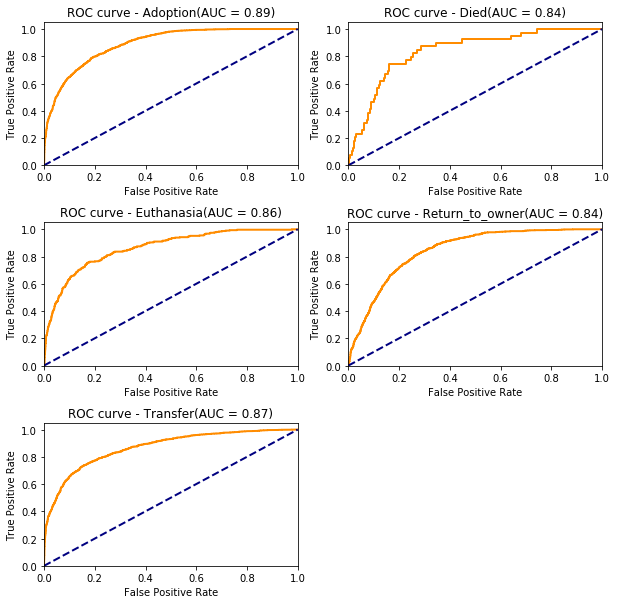

In [356]:
y_test_bin = label_binarize(y_test[:,0], GB.classes_)
plotROCCurves(GB.classes_, labelMapper.features[0][1].inverse_transform(GB.classes_), y_test_bin, proba)

In [357]:
from sklearn.metrics import confusion_matrix
print labelMapper.features[0][1].inverse_transform(GB.classes_)
cm = confusion_matrix(y_test[:,0], preds)#y_train[:,0]
print np.sum(preds==0)
print np.sum(y_test[:,0]==0)
print sum(cm[:,0])
cm


['Adoption' 'Died' 'Euthanasia' 'Return_to_owner' 'Transfer']
2521
2154
2521


array([[1771,    0,    0,  217,  166],
       [   6,    0,    0,    3,   30],
       [  52,    0,    6,   61,  192],
       [ 359,    0,    4,  467,  127],
       [ 333,    0,    3,  185, 1364]])

In [367]:
X_full, y_full = prepareDFForPrediction(df, df[["OutcomeType"]])
preclf.fit(X_full.values[:,final_support[:-1]], y_full.values.ravel())

y_full_simple=getSimpleOutcome(y_full.values)
     
GB.fit(np.hstack((X_full.values, np.array(y_full_simple)[np.newaxis].T))[:,final_support], y_full.values[:,0])

splitSex...
cleanupBreed...
processBreed...
(26729, 262)
processAge...
processDate...
processWeekend...
processName...
processColor...


XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.65000000000000002,
       colsample_bytree=0.37000000000000011, gamma=0,
       learning_rate=0.10000000000000001, max_delta_step=0, max_depth=500,
       min_child_weight=1, missing=None, n_estimators=250, n_jobs=2,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=3.0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.90000000000000013)

In [368]:
testdf = pd.read_csv("test.csv")

testdf, y = prepareDFForPrediction(testdf)

testdf.head()

splitSex...
cleanupBreed...
processBreed...
(11456, 262)
processAge...
processDate...
processWeekend...
processName...
processColor...


,AnimalType,Sex_female,Sex_male,Neutered,PureBreed,AgeBracket_adult,AgeBracket_baby,AgeBracket_juvenile,DaySegment_HR_0,DaySegment_HR_1,...,Breed_whippet,Breed_wire,Breed_wirehair,Breed_wirehaired,Breed_wolfhound,Breed_yorkshire,AgeDays,OutcomeDay,OutcomeMonth,OutcomeHour
0,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,300.0,12,10,12
1,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,730.0,26,7,17
2,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,365.0,13,1,12
3,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,120.0,28,12,18
4,1,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,730.0,24,9,17


In [370]:
X_kaggle_test = testdf.loc[:, testdf.columns!="ID"].values
print X_full.shape
print X_kaggle_test[:,final_support[:-1]].shape
prepreds = preclf.predict(X_kaggle_test[:,final_support[:-1]])
prepreds = np.reshape(prepreds, (len(prepreds), 1))

X_kaggle_test = np.hstack((X_kaggle_test, prepreds))
    
preds = GB.predict(X_kaggle_test[:,final_support])
probs = GB.predict_proba(X_kaggle_test[:,final_support])
print GB.classes_
print labelMapper.features[0][1].inverse_transform(GB.classes_)
results = np.concatenate((testdf[["ID"]].values, probs), axis=1)
resultsdf = pd.DataFrame(results, columns=["ID","Adoption","Died","Euthanasia","Return_to_owner","Transfer"])
resultsdf["ID"] = resultsdf["ID"].astype(int)
resultsdf.to_csv("results3csv", index=False)
resultsdf

(26729, 284)
(11456, 15)
[0 1 2 3 4]
['Adoption' 'Died' 'Euthanasia' 'Return_to_owner' 'Transfer']


,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,1,0.031514,0.000336,0.000506,0.112610,0.855034
1,2,0.033279,0.050378,0.898497,0.013922,0.003924
2,3,0.011964,0.053277,0.914328,0.009230,0.011200
3,4,0.013225,0.090163,0.868781,0.016408,0.011423
4,5,0.016155,0.031199,0.934108,0.014675,0.003863
5,6,0.225406,0.000444,0.000943,0.593531,0.179676
6,7,0.533888,0.004109,0.003552,0.214565,0.243885
7,8,0.861098,0.000800,0.000575,0.011222,0.126306
8,9,0.064058,0.108227,0.785801,0.029702,0.012212
9,10,0.016948,0.026580,0.939097,0.013246,0.004130
